# Exploratory Spatio-Temporal Data Analysis
# Part 3 - Descriptive Statistics - Monthly Summary Statistics

In [16]:
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
ds = xr.open_dataset('data/preprocessed_power_nasa_data.nc')

In [18]:
ds

<xarray.Dataset> Size: 169MB
Dimensions:            (timestamp: 8369, lat: 18, lon: 10)
Coordinates:
  * lat                (lat) float64 144B 5.0 5.5 6.0 6.5 ... 12.5 13.0 13.5
  * lon                (lon) float64 80B 36.25 36.88 37.5 ... 40.62 41.25 41.88
  * timestamp          (timestamp) datetime64[ns] 67kB 2001-01-01 ... 2023-11-30
Data variables: (12/14)
    PRECTOTCORR        (timestamp, lat, lon) float64 12MB ...
    EVPTRNS            (timestamp, lat, lon) float64 12MB ...
    T2M                (timestamp, lat, lon) float64 12MB ...
    TS                 (timestamp, lat, lon) float64 12MB ...
    CLOUD_AMT          (timestamp, lat, lon) float64 12MB ...
    PS                 (timestamp, lat, lon) float64 12MB ...
    ...                 ...
    QV2M               (timestamp, lat, lon) float64 12MB ...
    RH2M               (timestamp, lat, lon) float64 12MB ...
    ALLSKY_SFC_SW_DWN  (timestamp, lat, lon) float64 12MB ...
    GWETROOT           (timestamp, lat, lon) float64 12MB ...
    GWETPROF           (timestamp, lat, lon) float64 12MB ...
    GWETTOP            (timestamp, lat, lon) float64 12MB ...

## Descriptive statistics

### Summmary statistics

#### Daily Summary Statistics

In [19]:
def plot_daily_data_for_month(dataset, year, month, variable):
    """
    Plots daily climate data for a specific variable and month from an xarray.Dataset, focusing on Ethiopia.

    Parameters:
    - dataset (xarray.Dataset): The dataset containing the climate data.
    - year (int): The year of the data to plot.
    - month (int): The month of the data to plot (1 to 12).
    - variable (str): The variable to plot (e.g., 'PRECTOTCORR', 'T2M').

    This function visualizes each day's data within the specified month on a geographical map of Ethiopia.
    """
    # Define a custom colormap that starts with red and transitions to blue
    colors = ["red", "orange", "yellow", "green", "blue"]
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)

    # Filter data for the specific year and month
    monthly_data = dataset.sel(timestamp=slice(f"{year}-{month:02d}-01", f"{year}-{month:02d}-{pd.Timestamp(year, month, 1).days_in_month}"))

    # Number of days in the month
    num_days = len(monthly_data.timestamp)
    ncols = 7  # Display a week per row for visual alignment with a calendar
    nrows = (num_days + ncols - 1) // ncols  # Calculate the number of rows needed

    fig = plt.figure(figsize=(35, 3 * nrows), dpi=100)  # Increase the figure size for clarity

    # Define the geographic extent of Ethiopia
    ethiopia_extent = [33, 48, 3, 15]  # [lon_min, lon_max, lat_min, lat_max]

    for i, time in enumerate(monthly_data.timestamp):
        ax = fig.add_subplot(nrows, ncols, i + 1, projection=ccrs.PlateCarree())
        ax.coastlines(resolution='10m', color='black', linewidth=1)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_extent(ethiopia_extent, crs=ccrs.PlateCarree())  # Set the extent to cover Ethiopia
        
        # Plot the selected variable
        data_to_plot = monthly_data[variable].sel(timestamp=time)
        p = data_to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False,
                              vmin=0, vmax=1, cmap=cmap)  # Adjust vmin and vmax if needed
        ax.set_title(time.dt.strftime('%Y-%m-%d').values)

    # Adjust layout to not overlap plots
    plt.tight_layout()

    # Add a colorbar with positioning adjusted for the new figure layout
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(p, cax=cbar_ax, label=variable, extend='both')

    plt.show()


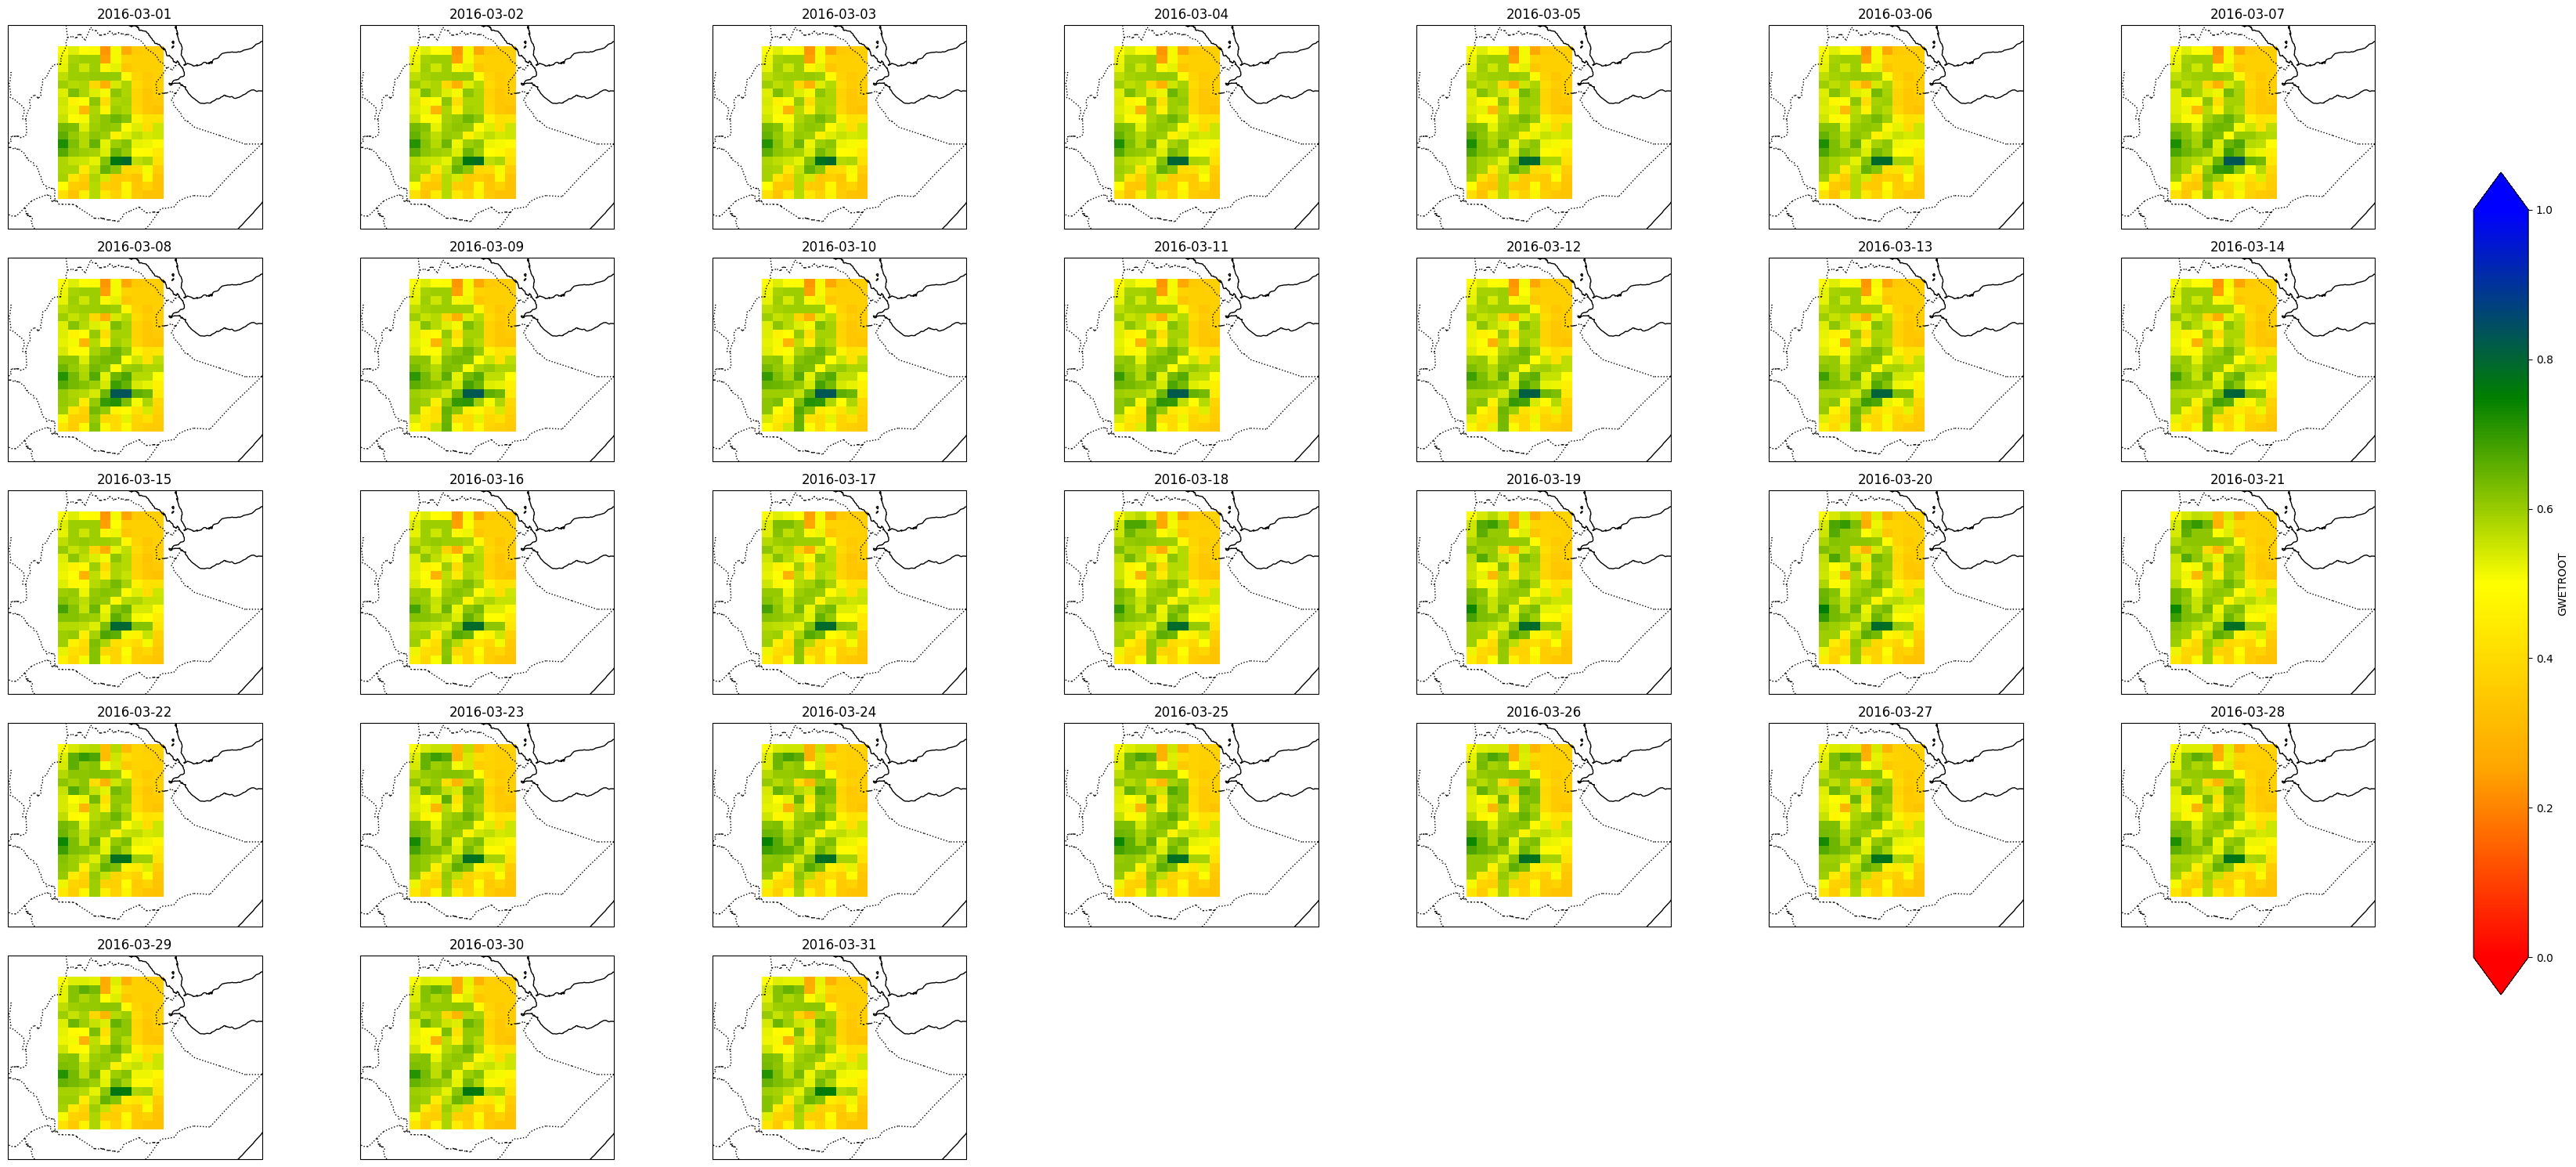

In [20]:
plot_daily_data_for_month(ds, 2016, 3, 'GWETROOT')

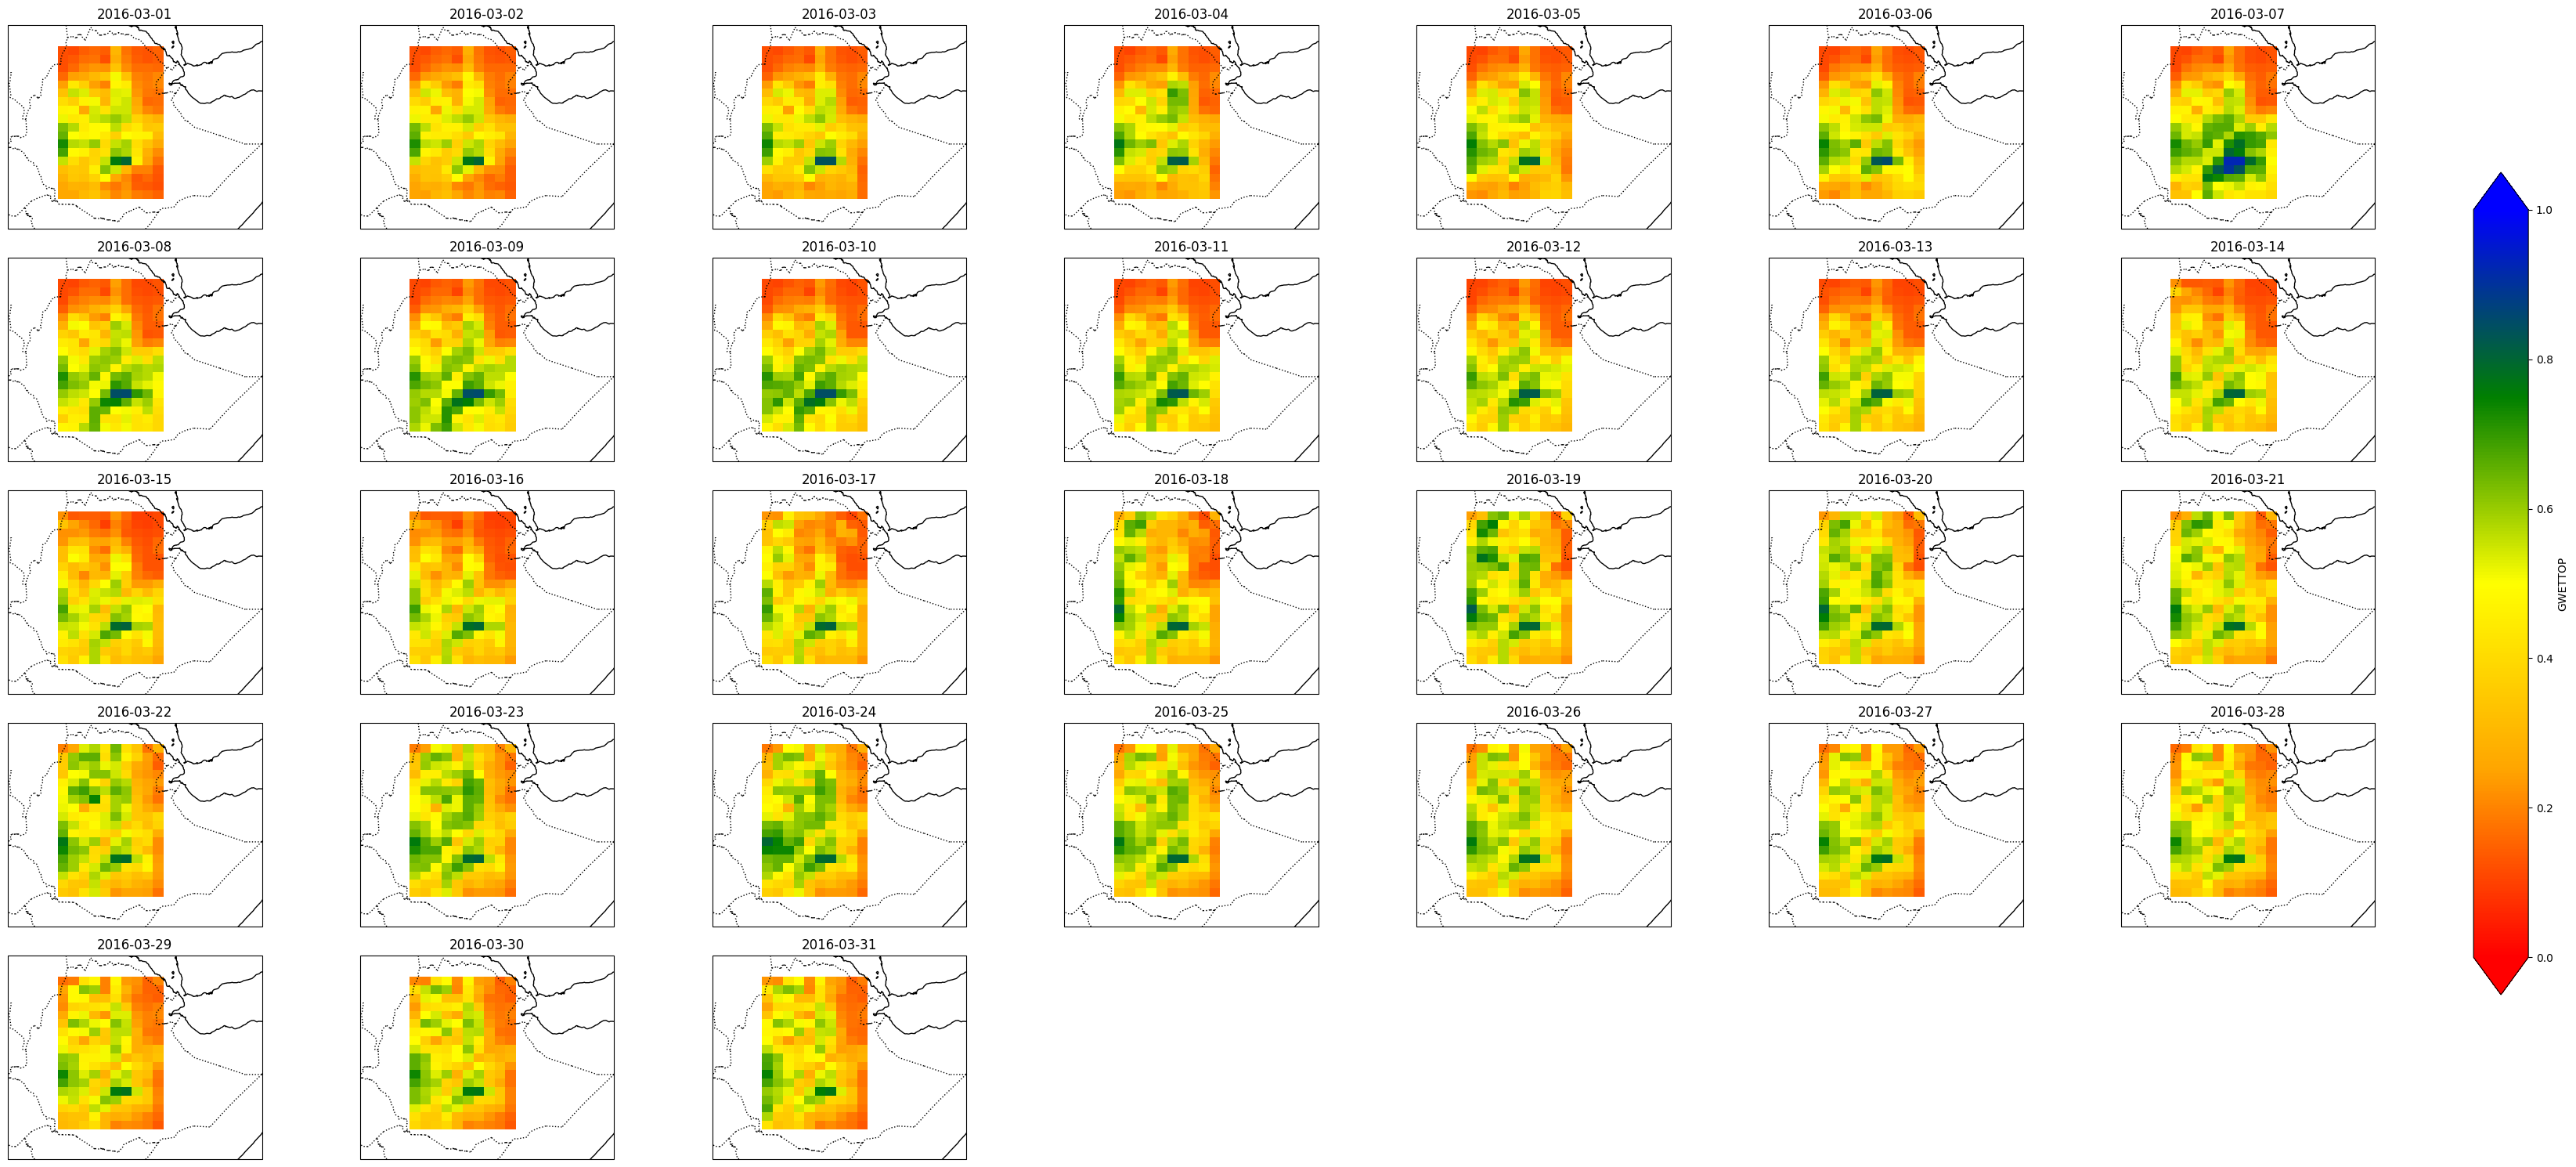

In [21]:
plot_daily_data_for_month(ds, 2016, 3, 'GWETTOP')

In [22]:
def decompose_seasonality_daily(ds, variable_name):
    """
    Decomposes a given variable from an xarray.Dataset to analyze daily seasonality.
    
    Parameters:
    - ds (xarray.Dataset): The dataset containing the variable.
    - variable_name (str): The name of the variable to analyze.
    
    This function performs the following steps:
    1. Averages the variable over latitude and longitude dimensions.
    2. Corrects negative values by setting them to zero.
    3. Converts the xarray.DataArray to a pandas DataFrame.
    4. Applies seasonal decomposition on the daily data with a weekly cycle.
    5. Plots the observed data, trend, seasonal, and residual components.
    
    Returns:
    - None: Plots the decomposition components.
    """
    
    # Check if the variable exists in the dataset
    if variable_name not in ds.variables:
        raise ValueError(f"Variable {variable_name} not found in the dataset.")
    
    # Average over the latitude and longitude dimensions
    data = ds[variable_name].mean(dim=['lat', 'lon'])

    # Correct negative values by setting them to zero
    data = data.where(data >= 0, 0)

    # Convert to pandas DataFrame for easier handling in statsmodels
    data_df = data.to_dataframe(name=variable_name).dropna()

    # The data is already at daily frequency, no resampling is needed

    # Decompose the time series to daily data
    # Assuming you want to see the weekly cycle, the period is set to 7
    decomposition = seasonal_decompose(data_df, model='additive', period=7)

    # Plot the decomposed components
    fig, axes = plt.subplots(4, 1, figsize=(12, 8))
    titles = ['Observed', 'Trend', 'Seasonal', 'Residual']
    for ax, component, title in zip(axes, [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid], titles):
        component.plot(ax=ax, title=title)
        ax.set_ylabel(variable_name)
        ax.label_outer()  # Hide x-labels for top 3 plots for clarity
    plt.tight_layout()
    plt.show()

# Usage example:
# decompose_seasonality_daily(ds, 'PRECTOTCORR')


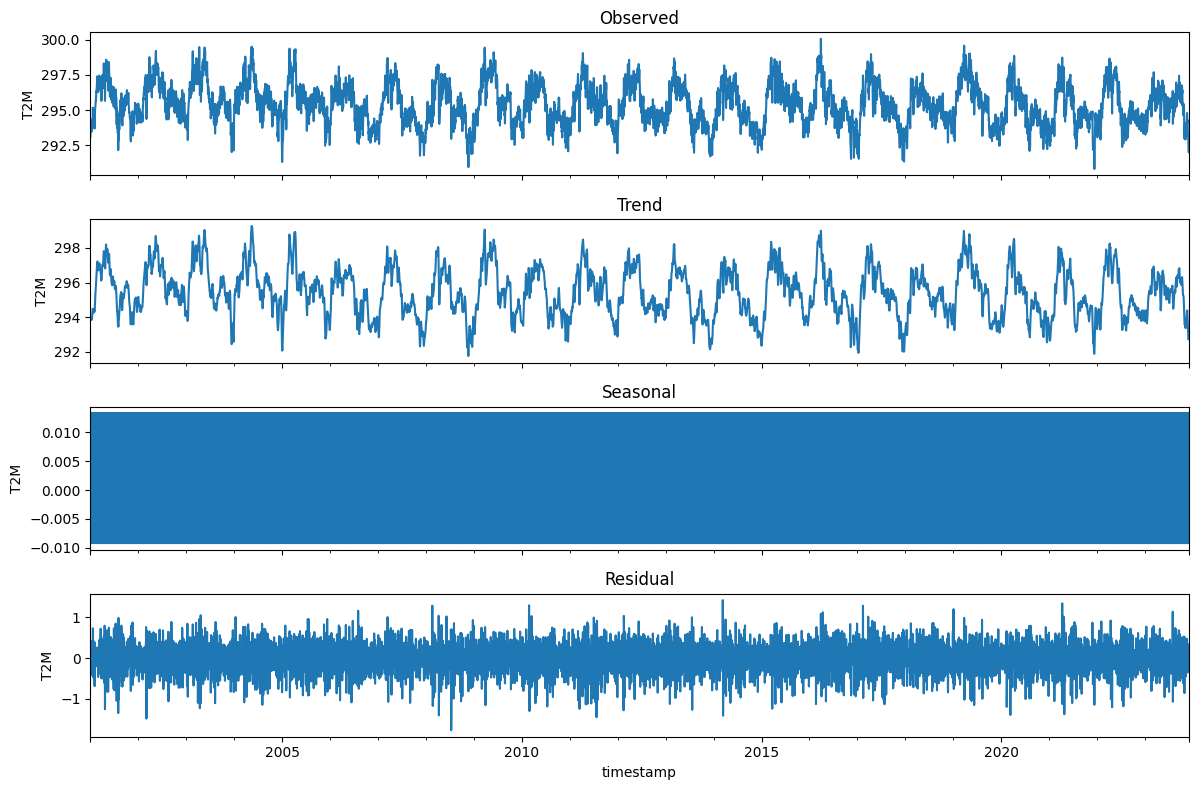

In [23]:
# Usage example:
decompose_seasonality_daily(ds, 'T2M')